In [7]:
!git clone https://github.com/gachonyws/face-mask-detector.git

Cloning into 'face-mask-detector'...
remote: Enumerating objects: 1302, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1302 (delta 0), reused 0 (delta 0), pack-reused 1298
Receiving objects: 100% (1302/1302), 74.61 MiB | 33.45 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [8]:
import tensorflow as tf

In [9]:
cd face-mask-detector

/content/face-mask-detector/face-mask-detector


In [10]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# 사진 속에서 얼굴을 탐지하는 face_detector 모델
facenet = cv2.dnn.readNet('face_detector/deploy.prototxt','face_detector/res10_300x300_ssd_iter_140000.caffemodel')
# 얼굴인식 후 마스크 착용 여부를 확인하는 모델
model = load_model('mask_detector.model')


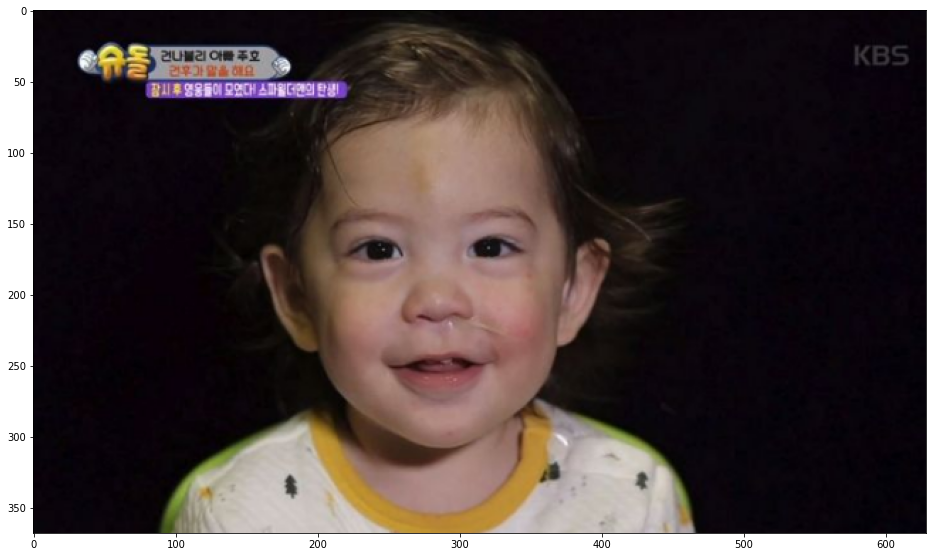

In [11]:
img = cv2.imread('/content/face-mask-detector/examples/박건후.png')
h,w = img.shape[:2]
plt.figure(figsize=(16,10))
plt.imshow(img[:,:,::-1]) # BGR -> RGB 변환


In [12]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300, 300), mean=
	(104.0, 177.0, 123.0))
facenet.setInput(blob) # 모델에 들어가는 input
detections = facenet.forward() # 결과를 inference

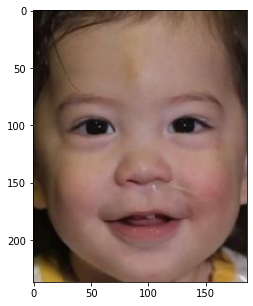

In [13]:
faces = []

# 사진속 얼굴 개수가 여러 개 있을 수 있으니 반복문 사용
for i in range(detections.shape[2]):
  confidence = detections[0,0,i,2]

  if confidence < 0.5:
    continue
  else:
     x1 = int(detections[0,0,i,3] * w)
     y1 = int(detections[0,0,i,4] * h)
     x2 = int(detections[0,0,i,5] * w)
     y2 = int(detections[0,0,i,6] * h)

     face = img[y1:y2, x1:x2]
     faces.append(face)

plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])

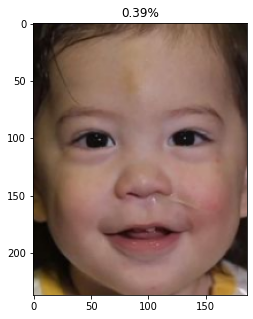

In [14]:
plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    face_input = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_input = cv2.resize(face_input, dsize=(224, 224))
    face_input = preprocess_input(face_input)
    face_input = np.expand_dims(face_input, axis=0)

    (mask, nomask) = model.predict(face_input)[0]

    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

cap = cv2.VideoCapture('examples/영상4.mp4')
ret, img = cap.read()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('./output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)

        mask, nomask = model.predict(face_input).squeeze()

        if mask > nomask:
            color = (0, 255, 0)
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255)
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    #cv2_imshow(result_img) # colab 환경에서 출력 때문에 계속 Busy 상태라 ignore
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
#import winsound

# facenet : 얼굴을 찾는 모델
facenet = cv2.dnn.readNet('models/deploy.prototxt', 'models/res10_300x300_ssd_iter_140000.caffemodel')
# model : 마스크 검출 모델
model = load_model('models/mask_detect.model')
or
# 동영상 파일 읽기
# cap = cv2.VideoCapture('imgs/01.mp4')
# 실시간 웹캠 읽기
cap = cv2.VideoCapture(0)
i = 0

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    # 이미지의 높이와 너비 추출
    h, w = img.shape[:2]

    # 이미지 전처리
    # ref. https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))

    # facenet의 input으로 blob을 설정
    facenet.setInput(blob)
    # facenet 결과 추론, 얼굴 추출 결과가 dets의 저장
    dets = facenet.forward()

    # 한 프레임 내의 여러 얼굴들을 받음
    result_img = img.copy()

    # 마스크를 착용했는지 확인
    for i in range(dets.shape[2]):

        # 검출한 결과가 신뢰도
        confidence = dets[0, 0, i, 2]
        # 신뢰도를 0.5로 임계치 지정
        if confidence < 0.5:
            continue

        # 바운딩 박스를 구함
        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        # 원본 이미지에서 얼굴영역 추출
        face = img[y1:y2, x1:x2]

        # 추출한 얼굴영역을 전처리
        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)

        # 마스크 검출 모델로 결과값 return
        mask, nomask = model.predict(face_input).squeeze()

        # 마스크를 꼈는지 안겼는지에 따라 라벨링해줌
        if mask > nomask:
            color = (0, 255, 0)
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255)
            label = 'No Mask %d%%' % (nomask * 100)
            frequency = 2500  # Set Frequency To 2500 Hertz
            duration = 1000  # Set Duration To 1000 ms == 1 second
            #winsound.Beep(frequency, duration)

        # 화면에 얼굴부분과 마스크 유무를 출력해해줌
        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8,
                    color=color, thickness=2, lineType=cv2.LINE_AA)

    cv2.imshow('img',result_img)

    # q를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

error: ignored

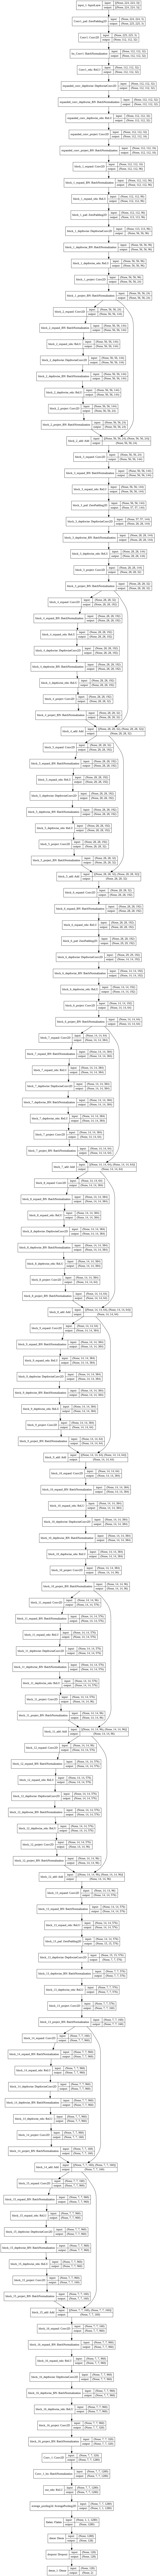

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)